## Training and testing of the DistilBert model on the train dataset (Reddit book reviews)

In [1]:
from transformers import DataCollatorWithPadding
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from datasets import load_dataset
from transformers import TrainingArguments, Trainer
from huggingface_hub import notebook_login
import numpy as np
import evaluate
import torch
from scipy.special import softmax
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import time


In [2]:
torch.manual_seed(42)


In [3]:
train_dataset = load_dataset("csv", data_files="books_train.csv")["train"]
test_dataset = load_dataset("csv", data_files="books_test.csv")["train"]

In [4]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [5]:
def preprocess_function(examples):
   return tokenizer(examples["body"], truncation=True)
 
tokenized_train = train_dataset.map(preprocess_function, batched=True)
tokenized_test = test_dataset.map(preprocess_function, batched=True)


In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [7]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Identifying the metrics for training the model

In [8]:
def compute_metrics(eval_pred):
   load_precision = evaluate.load("precision")
   load_f1 = evaluate.load("f1")
   logits, labels = eval_pred
   predictions = np.argmax(logits, axis=-1)
   precision = load_precision.compute(predictions=predictions, references=labels)
   f1 = load_f1.compute(predictions=predictions, references=labels)
   return {"precision": precision, "f1": f1}

In [9]:
repo_name = "finetuning-distibert-Reddit-books"
training_args = TrainingArguments(
   output_dir=repo_name,
   learning_rate=5e-5,
   per_device_train_batch_size=4,
   per_device_eval_batch_size=4,
   num_train_epochs=10,
   weight_decay=0.05,
   # save_strategy="steps",
   # push_to_hub=True,
   logging_steps=10,  # Print loss every 10 steps
   log_level="info",
   push_to_hub=False,
)
 
trainer = Trainer(
   model=model,
   args=training_args,
   train_dataset=tokenized_train,
   eval_dataset=tokenized_test,
   tokenizer=tokenizer,
   data_collator=data_collator,
   compute_metrics=compute_metrics,
)


/tmp/ipykernel_13075/2553017891.py:16: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [10]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: body. If body are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 200
  Num Epochs = 10
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 500
  Number of trainable parameters = 66,955,010


Step,Training Loss
10,0.551500
20,0.566500
30,0.553900
40,0.836500
50,0.658700
60,0.655300
70,0.620400
80,0.549700
90,0.700700
100,0.596800


Saving model checkpoint to finetuning-distibert-Reddit-books/checkpoint-500
Configuration saved in finetuning-distibert-Reddit-books/checkpoint-500/config.json
Model weights saved in finetuning-distibert-Reddit-books/checkpoint-500/model.safetensors
tokenizer config file saved in finetuning-distibert-Reddit-books/checkpoint-500/tokenizer_config.json
Special tokens file saved in finetuning-distibert-Reddit-books/checkpoint-500/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=500, training_loss=0.20488216817565263, metrics={'train_runtime': 84.6609, 'train_samples_per_second': 23.624, 'train_steps_per_second': 5.906, 'total_flos': 213337710633936.0, 'train_loss': 0.20488216817565263, 'epoch': 10.0})

In [11]:
trainer.evaluate()

The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: body. If body are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.

***** Running Evaluation *****
  Num examples = 100
  Batch size = 4


{'eval_loss': 1.7441729307174683,
 'eval_precision': {'precision': 0.7738095238095238},
 'eval_f1': {'f1': 0.8333333333333334},
 'eval_runtime': 3.2367,
 'eval_samples_per_second': 30.896,
 'eval_steps_per_second': 7.724,
 'epoch': 10.0}

## Calculating accuracy

In [13]:
inputs = tokenizer(test_dataset['body'], truncation=True, return_tensors="pt", padding=True).to("cpu")
model_cpu = model.to("cpu")
with torch.no_grad():
    logits = model_cpu(**inputs).logits


predictions = np.argmax(logits, axis=-1)
labels = test_dataset["label"]
load_accuracy = evaluate.load("accuracy")
accuracy = load_accuracy.compute(predictions=predictions, references=labels)
print({"accuracy": accuracy})

{'accuracy': {'accuracy': 0.74}}


### Accuracy is 0.74, precision is 0.77, F1-score is 0.83

In [14]:
#logits of the inference on the testing data
Reddit_dbert_logits = logits.numpy()

## PR curve: calculating precision and recall

In [15]:
y_true = np.array(test_dataset["label"])
Reddit_dbert_precision = []
Reddit_dbert_recall = []
Reddit_dbert_probabilities = softmax(Reddit_dbert_logits, axis=1)
threshold = list(np.arange(0.0, 1, 0.001))
for t in threshold:
    y_scores = (Reddit_dbert_probabilities[:, 1] > t).astype(int)
    Reddit_dbert_precision.append(precision_score(y_true, y_scores, zero_division=1))
    Reddit_dbert_recall.append(recall_score(y_true, y_scores, zero_division=1))

Reddit_dbert_precision.append(1)
Reddit_dbert_recall.append(0)

## Baseline model which always returns the most frequent class


In [16]:
y_score_baseline = np.ones(y_true.shape)
baseline_precision = precision_score(y_true, y_score_baseline, zero_division=1)
baseline_recall = recall_score(y_true, y_score_baseline, zero_division=1)

## Plotting the PR curve

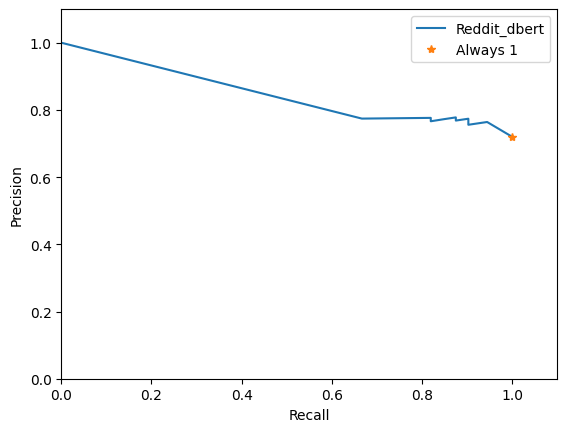

In [17]:
fig, ax = plt.subplots()
ax.plot(Reddit_dbert_recall, Reddit_dbert_precision, '-', label='Reddit_dbert')
ax.plot([baseline_recall], [baseline_precision], '*', label='Always 1')
ax.set_xlabel('Recall')
ax.set_ylabel('Precision')
ax.set_xlim((0, 1.1))
ax.set_ylim((0, 1.1))
ax.legend()

In [18]:
np.savetxt("Reddit_dbert_logits.csv", Reddit_dbert_logits, delimiter = ",")

## Estimating inference time

In [19]:
time_start = time.perf_counter()
model_cpu = model.to("cpu")

for text in test_dataset["body"]:
        request = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to('cpu')
        outputs = model_cpu(**request)

time_end = time.perf_counter()
    
print(f'Took {(time_end - time_start):.3f} seconds')

Took 6.206 seconds
